Enhanced Green AI + XAI for Medical Image Classification
1. Loading data...
🧹 Cleaning metadata...
Cleaned: 10015 → 7418 samples
Loading training images...
Loaded 500 images...
Loaded 1000 images...
Loaded 1500 images...
Loaded 2000 images...
Loading validation images...
Loaded 500 images...
Successfully loaded 2000 training and 500 validation images

2. Creating models...

3. Training models...

Training Green_Baseline...
Class weights: {0: 1.272264631043257, 1: 0.5837711617046117, 2: 5.649717514124294, 3: 0.6816632583503749, 4: 0.6161429451632778, 5: 4.273504273504273}
Best val accuracy: 0.6000
CO2 emissions: 0.003 kg

Training Step_Wise_CNN...
Class weights: {0: 1.272264631043257, 1: 0.5837711617046117, 2: 5.649717514124294, 3: 0.6816632583503749, 4: 0.6161429451632778, 5: 4.273504273504273}
Best val accuracy: 0.7000
CO2 emissions: 0.012 kg

Training EfficientNet_B0...
Class weights: {0: 1.272264631043257, 1: 0.5837711617046117, 2: 5.649717514124294, 3: 0.6816632583503749, 4: 0.6161

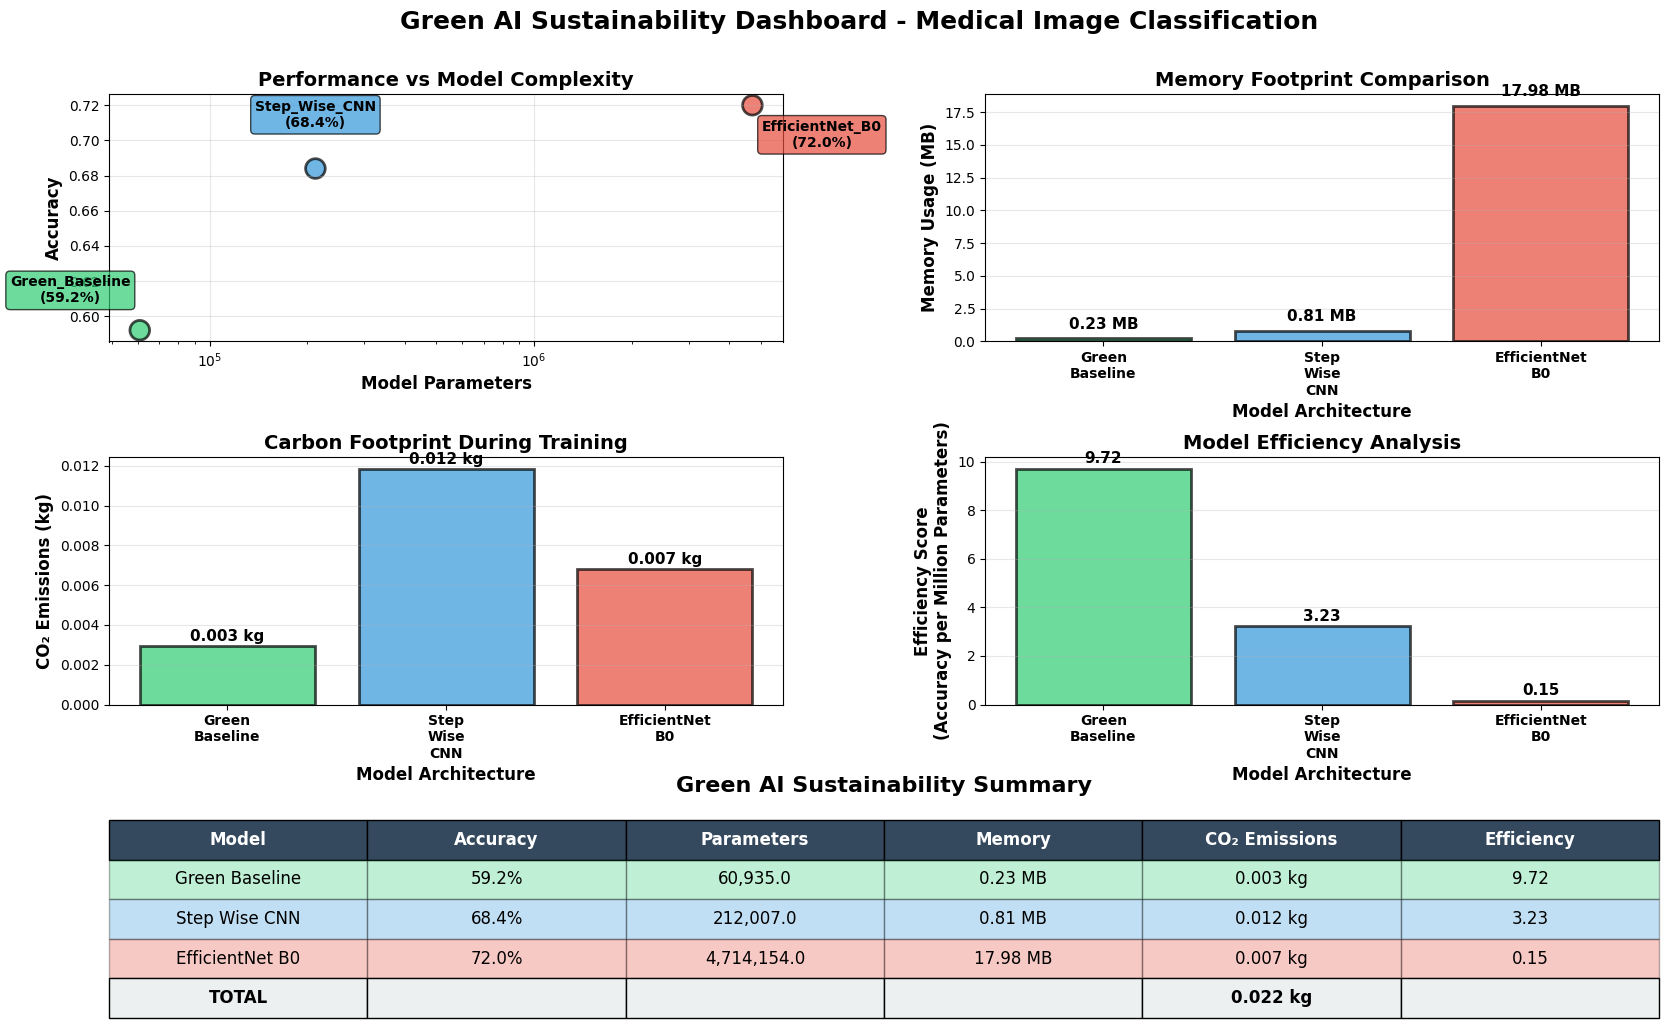


6. XAI demonstrations...

Sample 1: True=nv, Pred=nv


  0%|          | 0/100 [00:00<?, ?it/s]

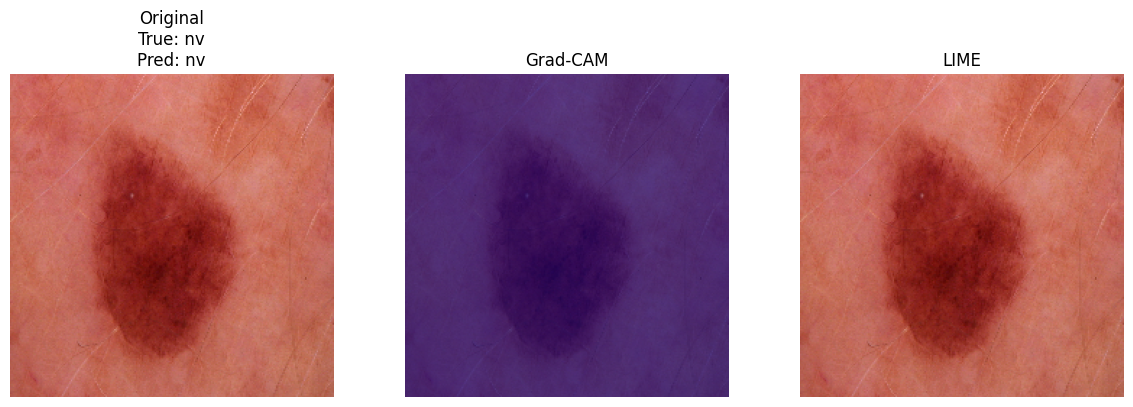


Sample 2: True=nv, Pred=nv


  0%|          | 0/100 [00:00<?, ?it/s]

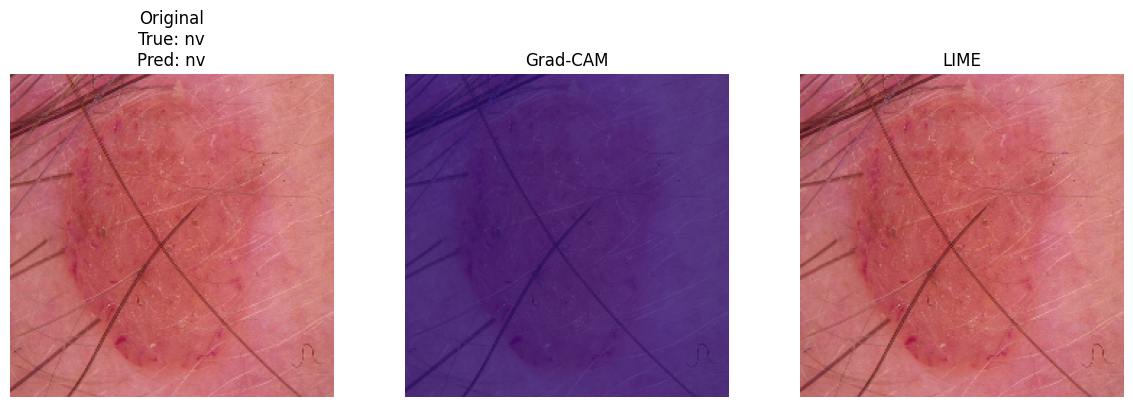


Sample 3: True=nv, Pred=nv


  0%|          | 0/100 [00:00<?, ?it/s]

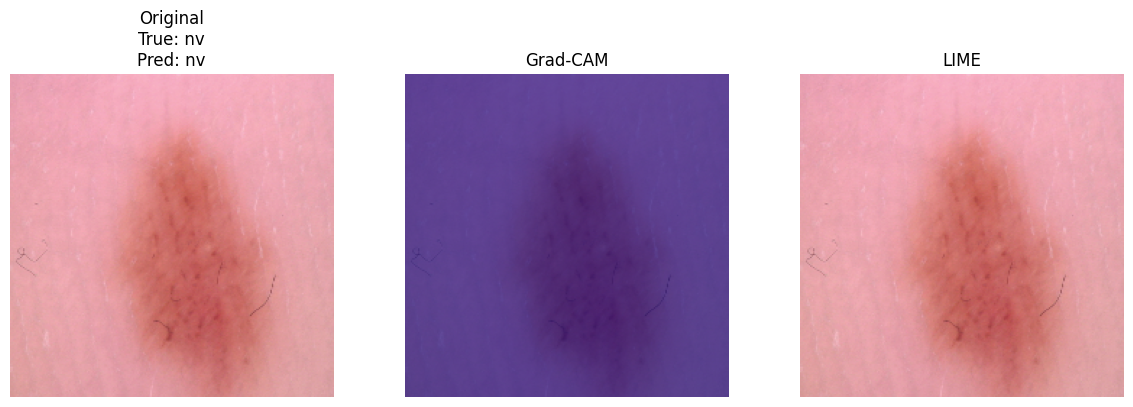


✅ Analysis Complete!
Best model: EfficientNet_B0 (0.7200 accuracy)
Total CO2: 0.022 kg


In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import lime
from lime import lime_image
import warnings
warnings.filterwarnings('ignore')
import cv2
from scipy import ndimage
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0, DenseNet121
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
import time
import os
import glob
from PIL import Image

tf.random.set_seed(42)
np.random.seed(42)

class EnhancedGreenAIXAI:
    def __init__(self, image_size=(224, 224)):
        self.image_size = image_size
        self.num_classes = 7
        self.class_names = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
        self.class_weights = None
        self.setup_data_augmentation()
        
    def calculate_class_weights(self, y):
        y_integers = np.argmax(y, axis=1)
        class_weights = compute_class_weight('balanced', classes=np.unique(y_integers), y=y_integers)
        self.class_weights = {i: class_weights[i] for i in range(len(class_weights))}
        print(f"Class weights: {self.class_weights}")
        return self.class_weights
    
    def setup_data_augmentation(self):
        self.data_augmentation = ImageDataGenerator(
            rotation_range=30, width_shift_range=0.15, height_shift_range=0.15,
            shear_range=0.15, zoom_range=0.15, horizontal_flip=True, vertical_flip=True,
            fill_mode='nearest', brightness_range=[0.7, 1.3], channel_shift_range=0.2,
            rescale=1./255
        )
    
    def preprocess_image(self, image):
        if isinstance(image, np.ndarray):
            if image.dtype != np.uint8:
                if image.max() <= 1.0:
                    image = (image * 255).astype(np.uint8)
                else:
                    image = image.astype(np.uint8)
        
        if len(image.shape) == 2:
            image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
        elif len(image.shape) == 3 and image.shape[2] == 1:
            image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
        elif len(image.shape) == 3 and image.shape[2] == 4:
            image = cv2.cvtColor(image, cv2.COLOR_RGBA2RGB)
        
        try:
            if image.shape[:2] != self.image_size:
                image = cv2.resize(image, self.image_size, interpolation=cv2.INTER_LANCZOS4)
        except:
            zoom_factors = (self.image_size[0] / image.shape[0], self.image_size[1] / image.shape[1], 1)
            image = ndimage.zoom(image, zoom_factors, order=1).astype(np.uint8)
        
        image = image.astype(np.float32) / 255.0
        return np.clip(image, 0, 1)
    
    def clean_metadata(self, metadata_df):
        print("🧹 Cleaning metadata...")
        original_size = len(metadata_df)
        
        # Remove missing critical data
        critical_columns = ['dx', 'lesion_id']
        for col in critical_columns:
            if col in metadata_df.columns:
                metadata_df = metadata_df.dropna(subset=[col])
        
        # Remove duplicates
        if 'lesion_id' in metadata_df.columns:
            metadata_df = metadata_df.drop_duplicates(subset=['lesion_id'], keep='first')
        
        # Clean age
        if 'age' in metadata_df.columns:
            metadata_df = metadata_df[(metadata_df['age'] >= 0) & (metadata_df['age'] <= 120)]
            if metadata_df['age'].isnull().any():
                metadata_df['age'].fillna(metadata_df['age'].median(), inplace=True)
        
        # Validate diagnosis
        valid_diagnoses = set(self.class_names)
        metadata_df = metadata_df[metadata_df['dx'].isin(valid_diagnoses)]
        
        print(f"Cleaned: {original_size} → {len(metadata_df)} samples")
        return metadata_df

    def _generate_dummy_data(self):
        print("Generating dummy data...")
        n_samples = 3000
        X = np.random.rand(n_samples, *self.image_size, 3)
        # Fix probability sum to 1
        class_probs = [0.0327, 0.0514, 0.1099, 0.0115, 0.1113, 0.6705, 0.1127]
        class_probs = np.array(class_probs) / np.sum(class_probs)  # Normalize to sum=1
        y = np.random.choice(self.num_classes, n_samples, p=class_probs)
        y = tf.keras.utils.to_categorical(y, self.num_classes)
        return train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    
    def load_and_preprocess_data(self):
        try:
            # HAM10000 paths - adapt to your environment
            data_dir = '/kaggle/input/skin-cancer-mnist-ham10000'
            
            # Try to find image files
            all_image_paths = []
            for ext in ['*.jpg', '*.jpeg', '*.png']:
                all_image_paths.extend(glob.glob(os.path.join(data_dir, '**', ext), recursive=True))
            
            if not all_image_paths:
                print("No image files found. Using dummy data.")
                return self._generate_dummy_data()
            
            # Create image_id to path mapping
            imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x for x in all_image_paths}
            
            # Load metadata
            metadata_path = os.path.join(data_dir, 'HAM10000_metadata.csv')
            if not os.path.exists(metadata_path):
                print("Metadata file not found. Using dummy data.")
                return self._generate_dummy_data()
                
            df_original = pd.read_csv(metadata_path)
            df_original = self.clean_metadata(df_original)
            
            # Map image paths
            df_original['path'] = df_original['image_id'].map(imageid_path_dict.get)
            df_original = df_original.dropna(subset=['path'])  # Remove rows without image files
            
            if len(df_original) == 0:
                print("No matching images found. Using dummy data.")
                return self._generate_dummy_data()
            
            # Handle duplicates properly (same as Kaggle notebook)
            df_undup = df_original.groupby('lesion_id').count()
            df_undup = df_undup[df_undup['image_id'] == 1]
            unique_lesions = set(df_undup.index)
            
            def get_duplicates(lesion_id):
                return 'unduplicated' if lesion_id in unique_lesions else 'duplicated'
            
            df_original['duplicates'] = df_original['lesion_id'].apply(get_duplicates)
            
            # Create validation set from unduplicated images
            df_undup = df_original[df_original['duplicates'] == 'unduplicated']
            if len(df_undup) == 0:
                print("No unduplicated images found. Using all data.")
                df_undup = df_original
            
            # Split for validation
            y_undup = df_undup['dx']
            try:
                _, df_val = train_test_split(df_undup, test_size=0.2, random_state=42, stratify=y_undup)
            except:
                _, df_val = train_test_split(df_undup, test_size=0.2, random_state=42)
            
            # Create train set (all images not in validation)
            val_image_ids = set(df_val['image_id'])
            df_train = df_original[~df_original['image_id'].isin(val_image_ids)]
            
            # Balance classes (data augmentation rates)
            data_aug_rate = [15, 10, 5, 50, 0, 40, 5]  # From Kaggle notebook
            label_map = {label: idx for idx, label in enumerate(self.class_names)}
            df_train['cell_type_idx'] = df_train['dx'].map(label_map)
            
            for i in range(7):
                if data_aug_rate[i] > 1:
                    class_data = df_train[df_train['cell_type_idx'] == i]
                    if len(class_data) > 0:
                        augmented = pd.concat([class_data] * (data_aug_rate[i] - 1), ignore_index=True)
                        df_train = pd.concat([df_train, augmented], ignore_index=True)
            
            # Load and preprocess images
            def load_images_from_df(df, max_samples=3000):
                images, labels = [], []
                processed = 0
                
                for idx, row in df.iterrows():
                    if processed >= max_samples:
                        break
                    
                    try:
                        if pd.isna(row['path']) or not os.path.exists(row['path']):
                            continue
                            
                        # Load image
                        img = cv2.imread(row['path'])
                        if img is None:
                            continue
                            
                        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                        img_processed = self.preprocess_image(img)
                        
                        if np.isnan(img_processed).any() or np.isinf(img_processed).any():
                            continue
                        
                        images.append(img_processed)
                        labels.append(row['dx'])
                        processed += 1
                        
                        if processed % 500 == 0:
                            print(f"Loaded {processed} images...")
                            
                    except Exception as e:
                        continue
                
                return images, labels
            
            # Load train and validation images
            print("Loading training images...")
            train_images, train_labels = load_images_from_df(df_train, max_samples=2000)
            
            print("Loading validation images...")
            val_images, val_labels = load_images_from_df(df_val, max_samples=500)
            
            if len(train_images) == 0 or len(val_images) == 0:
                print("Insufficient images loaded. Using dummy data.")
                return self._generate_dummy_data()
            
            # Convert to arrays
            X_train = np.array(train_images)
            X_val = np.array(val_images)
            
            # Convert labels
            y_train_indices = [label_map.get(label, 5) for label in train_labels]
            y_val_indices = [label_map.get(label, 5) for label in val_labels]
            
            y_train = tf.keras.utils.to_categorical(y_train_indices, self.num_classes)
            y_val = tf.keras.utils.to_categorical(y_val_indices, self.num_classes)
            
            print(f"Successfully loaded {len(X_train)} training and {len(X_val)} validation images")
            
            # Create test set from validation set
            X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, random_state=42, stratify=y_val)
            
            return X_train, X_test, y_train, y_test, X_val, y_val
            
        except Exception as e:
            print(f"Error loading HAM10000 data: {e}. Using dummy data.")
            return self._generate_dummy_data_split()
    
    def _generate_dummy_data_split(self):
        """Generate dummy data with train/val/test splits"""
        print("Generating dummy data...")
        n_samples = 3000
        X = np.random.rand(n_samples, *self.image_size, 3)
        class_probs = [0.0327, 0.0514, 0.1099, 0.0115, 0.1113, 0.6705, 0.1127]
        class_probs = np.array(class_probs) / np.sum(class_probs)
        y = np.random.choice(self.num_classes, n_samples, p=class_probs)
        y = tf.keras.utils.to_categorical(y, self.num_classes)
        
        X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)
        X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)
        
        return X_train, X_test, y_train, y_test, X_val, y_val

    def create_green_model(self):
        return tf.keras.Sequential([
            tf.keras.layers.Conv2D(32, 3, activation='relu', input_shape=(*self.image_size, 3)),
            tf.keras.layers.MaxPooling2D(),
            tf.keras.layers.Conv2D(64, 3, activation='relu'),
            tf.keras.layers.MaxPooling2D(),
            tf.keras.layers.Conv2D(64, 3, activation='relu'),
            tf.keras.layers.GlobalAveragePooling2D(),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(self.num_classes, activation='softmax')
        ])

    def create_step_wise_cnn_model(self):
        return tf.keras.Sequential([
            tf.keras.layers.Conv2D(32, 3, activation='relu', padding='same', input_shape=(*self.image_size, 3)),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Conv2D(32, 3, activation='relu', padding='same'),
            tf.keras.layers.MaxPooling2D(2, 2),
            tf.keras.layers.Dropout(0.25),
            tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same'),
            tf.keras.layers.MaxPooling2D(2, 2),
            tf.keras.layers.Dropout(0.25),
            tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.GlobalAveragePooling2D(),
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Dense(512, activation='relu'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(self.num_classes, activation='softmax')
        ])
    
    def create_efficientnet_model(self):
        base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(*self.image_size, 3))
        base_model.trainable = True
        for layer in base_model.layers[:-20]:
            layer.trainable = False
        
        return tf.keras.Sequential([
            base_model,
            tf.keras.layers.GlobalAveragePooling2D(),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Dense(512, activation='relu'),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(self.num_classes, activation='softmax')
        ])
    
    def calculate_model_efficiency(self, model):
        model_size = model.count_params()
        return {
            'parameters': model_size,
            'memory_mb': model_size * 4 / (1024**2)
        }
    
    def calculate_carbon_footprint(self, model, training_time_hours):
        energy_consumed = training_time_hours * 0.5
        return {
            'training_time_hours': training_time_hours,
            'energy_kwh': energy_consumed,
            'carbon_kg_co2': energy_consumed * 0.5
        }
    
    def enhanced_train_model(self, model, X_train, y_train, X_val, y_val, epochs=50):
        class_weights = self.calculate_class_weights(y_train)
        
        model.compile(
            optimizer=tf.keras.optimizers.AdamW(learning_rate=0.0001, weight_decay=0.0001),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )
        
        callbacks = [
            EarlyStopping(patience=15, restore_best_weights=True, monitor='val_accuracy'),
            ReduceLROnPlateau(patience=7, factor=0.3, min_lr=1e-7, monitor='val_loss'),
            ModelCheckpoint('best_model.weights.h5', save_best_only=True, monitor='val_accuracy', 
                           save_weights_only=True, mode='max')
        ]
        
        start_time = time.time()
        history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs,
                           batch_size=16, callbacks=callbacks, class_weight=class_weights, verbose=0)
        
        training_time = (time.time() - start_time) / 3600
        carbon_info = self.calculate_carbon_footprint(model, training_time)
        
        print(f"Best val accuracy: {max(history.history['val_accuracy']):.4f}")
        print(f"CO2 emissions: {carbon_info['carbon_kg_co2']:.3f} kg")
        
        return history, carbon_info
    
    def compare_models(self, models_dict, X_test, y_test):
        results = {}
        for name, model in models_dict.items():
            predictions = model.predict(X_test, verbose=0)
            predicted_classes = np.argmax(predictions, axis=1)
            true_classes = np.argmax(y_test, axis=1)
            
            accuracy = np.mean(predicted_classes == true_classes)
            precision = precision_score(true_classes, predicted_classes, average='weighted', zero_division=0)
            recall = recall_score(true_classes, predicted_classes, average='weighted', zero_division=0)
            f1 = f1_score(true_classes, predicted_classes, average='weighted', zero_division=0)
            
            efficiency = self.calculate_model_efficiency(model)
            
            results[name] = {
                'accuracy': accuracy,
                'precision': precision,
                'recall': recall,
                'f1_score': f1,
                'parameters': efficiency['parameters'],
                'memory_mb': efficiency['memory_mb']
            }
        
        return pd.DataFrame(results).T
    
    def create_enhanced_sustainability_dashboard(self, comparison_df, carbon_footprints):
        """
        Creates a comprehensive and readable sustainability dashboard
        that includes all Green AI metrics without overlapping text
        """
        # Create figure with better layout
        fig = plt.figure(figsize=(20, 12))
        
        # Main title
        fig.suptitle('Green AI Sustainability Dashboard - Medical Image Classification', 
                     fontsize=18, fontweight='bold', y=0.95)
        
        # Create a 3x2 grid for better organization
        gs = fig.add_gridspec(3, 2, height_ratios=[1, 1, 0.8], hspace=0.5, wspace=0.3)
        
        # Extract carbon footprint data
        carbon_data = {name: carbon_footprints[name]['carbon_kg_co2'] for name in comparison_df.index}
        
        # 1. Model Performance vs Parameters (Top Left)
        ax1 = fig.add_subplot(gs[0, 0])
        colors = ['#2ecc71', '#3498db', '#e74c3c']  # Green, Blue, Red
        
        scatter = ax1.scatter(comparison_df['parameters'], comparison_df['accuracy'], 
                             c=colors, s=200, alpha=0.7, edgecolors='black', linewidth=2)
        
        # Add clean labels without overlap
        for i, (model, color) in enumerate(zip(comparison_df.index, colors)):
            x = comparison_df.iloc[i]['parameters']
            y = comparison_df.iloc[i]['accuracy']
            
            # Position labels strategically to avoid overlap
            if 'Green' in model:
                ax1.annotate(f'{model}\n({y:.1%})', (x, y), 
                            xytext=(-50, 20), textcoords='offset points',
                            bbox=dict(boxstyle='round,pad=0.3', facecolor=color, alpha=0.7),
                            fontsize=10, fontweight='bold', ha='center')
            elif 'Step' in model:
                ax1.annotate(f'{model}\n({y:.1%})', (x, y), 
                            xytext=(0, 30), textcoords='offset points',
                            bbox=dict(boxstyle='round,pad=0.3', facecolor=color, alpha=0.7),
                            fontsize=10, fontweight='bold', ha='center')
            else:
                ax1.annotate(f'{model}\n({y:.1%})', (x, y), 
                            xytext=(50, -30), textcoords='offset points',
                            bbox=dict(boxstyle='round,pad=0.3', facecolor=color, alpha=0.7),
                            fontsize=10, fontweight='bold', ha='center')
        
        ax1.set_xlabel('Model Parameters', fontsize=12, fontweight='bold')
        ax1.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
        ax1.set_title('Performance vs Model Complexity', fontsize=14, fontweight='bold')
        ax1.grid(True, alpha=0.3)
        ax1.set_xscale('log')
        
        # 2. Memory Usage Comparison (Top Right)
        ax2 = fig.add_subplot(gs[0, 1])
        bars = ax2.bar(range(len(comparison_df)), comparison_df['memory_mb'], 
                       color=colors, alpha=0.7, edgecolor='black', linewidth=2)
        
        # Add value labels on bars
        for i, (bar, model) in enumerate(zip(bars, comparison_df.index)):
            height = bar.get_height()
            ax2.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                    f'{height:.2f} MB', ha='center', va='bottom', 
                    fontsize=11, fontweight='bold')
        
        ax2.set_xlabel('Model Architecture', fontsize=12, fontweight='bold')
        ax2.set_ylabel('Memory Usage (MB)', fontsize=12, fontweight='bold')
        ax2.set_title('Memory Footprint Comparison', fontsize=14, fontweight='bold')
        ax2.set_xticks(range(len(comparison_df)))
        ax2.set_xticklabels([name.replace('_', '\n') for name in comparison_df.index], 
                           fontsize=10, fontweight='bold')
        ax2.grid(True, alpha=0.3, axis='y')
        
        # 3. Carbon Footprint Analysis (Middle Left)
        ax3 = fig.add_subplot(gs[1, 0])
        carbon_values = list(carbon_data.values())
        bars3 = ax3.bar(range(len(carbon_data)), carbon_values, 
                        color=colors, alpha=0.7, edgecolor='black', linewidth=2)
        
        # Add value labels
        for i, (bar, value) in enumerate(zip(bars3, carbon_values)):
            height = bar.get_height()
            ax3.text(bar.get_x() + bar.get_width()/2., height + 0.0001,
                    f'{value:.3f} kg', ha='center', va='bottom', 
                    fontsize=11, fontweight='bold')
        
        ax3.set_xlabel('Model Architecture', fontsize=12, fontweight='bold')
        ax3.set_ylabel('CO₂ Emissions (kg)', fontsize=12, fontweight='bold')
        ax3.set_title('Carbon Footprint During Training', fontsize=14, fontweight='bold')
        ax3.set_xticks(range(len(carbon_data)))
        ax3.set_xticklabels([name.replace('_', '\n') for name in carbon_data.keys()], 
                           fontsize=10, fontweight='bold')
        ax3.grid(True, alpha=0.3, axis='y')
        
        # 4. Efficiency Score (Middle Right)
        ax4 = fig.add_subplot(gs[1, 1])
        efficiency_scores = comparison_df['accuracy'] / (comparison_df['parameters'] / 1e6)
        bars4 = ax4.bar(range(len(efficiency_scores)), efficiency_scores, 
                        color=colors, alpha=0.7, edgecolor='black', linewidth=2)
        
        # Add value labels
        for i, (bar, score) in enumerate(zip(bars4, efficiency_scores)):
            height = bar.get_height()
            ax4.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                    f'{score:.2f}', ha='center', va='bottom', 
                    fontsize=11, fontweight='bold')
        
        ax4.set_xlabel('Model Architecture', fontsize=12, fontweight='bold')
        ax4.set_ylabel('Efficiency Score\n(Accuracy per Million Parameters)', fontsize=12, fontweight='bold')
        ax4.set_title('Model Efficiency Analysis', fontsize=14, fontweight='bold')
        ax4.set_xticks(range(len(efficiency_scores)))
        ax4.set_xticklabels([name.replace('_', '\n') for name in comparison_df.index], 
                           fontsize=10, fontweight='bold')
        ax4.grid(True, alpha=0.3, axis='y')
        
        # 5. Summary Statistics Table (Bottom)
        ax5 = fig.add_subplot(gs[2, :])
        ax5.axis('tight')
        ax5.axis('off')
        
        # Create summary table
        summary_data = []
        for model in comparison_df.index:
            row = [
                model.replace('_', ' '),
                f"{comparison_df.loc[model, 'accuracy']:.1%}",
                f"{comparison_df.loc[model, 'parameters']:,}",
                f"{comparison_df.loc[model, 'memory_mb']:.2f} MB",
                f"{carbon_data[model]:.3f} kg",
                f"{efficiency_scores[model]:.2f}"
            ]
            summary_data.append(row)
        
        # Add total row
        total_co2 = sum(carbon_data.values())
        summary_data.append([
            'TOTAL', '', '', '', f"{total_co2:.3f} kg", ''
        ])
        
        table = ax5.table(cellText=summary_data,
                         colLabels=['Model', 'Accuracy', 'Parameters', 'Memory', 'CO₂ Emissions', 'Efficiency'],
                         cellLoc='center',
                         loc='center',
                         bbox=[0, 0, 1, 1])
        
        # Style the table
        table.auto_set_font_size(False)
        table.set_fontsize(12)
        table.scale(1, 2)
        
        # Color code the header
        for i in range(6):
            table[(0, i)].set_facecolor('#34495e')
            table[(0, i)].set_text_props(weight='bold', color='white')
        
        # Color code the total row
        for i in range(6):
            table[(4, i)].set_facecolor('#ecf0f1')
            table[(4, i)].set_text_props(weight='bold')
        
        # Color code model rows
        for i, color in enumerate(colors):
            for j in range(6):
                table[(i+1, j)].set_facecolor(color)
                table[(i+1, j)].set_alpha(0.3)
        
        ax5.set_title('Green AI Sustainability Summary', fontsize=16, fontweight='bold', pad=20)
        
        plt.tight_layout()
        plt.savefig('green_ai_sustainability_dashboard.png', dpi=300, bbox_inches='tight', 
                    facecolor='white', edgecolor='none')
        plt.show()
        
        return fig
    
    def visualize_results(self, comparison_df, carbon_footprints):
        """
        REPLACED: Enhanced visualization function that creates comprehensive dashboard
        """
        return self.create_enhanced_sustainability_dashboard(comparison_df, carbon_footprints)
    
    def generate_gradcam(self, model, image, class_idx):
        layer_name = None
        for layer in reversed(model.layers):
            if hasattr(layer, 'output_shape') and len(layer.output_shape) == 4:
                layer_name = layer.name
                break
        
        if layer_name is None:
            return np.zeros(self.image_size)
        
        try:
            grad_model = tf.keras.Model(inputs=model.input, outputs=[model.get_layer(layer_name).output, model.output])
            
            with tf.GradientTape() as tape:
                conv_outputs, predictions = grad_model(np.expand_dims(image, axis=0))
                loss = predictions[:, class_idx]
            
            grads = tape.gradient(loss, conv_outputs)
            pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
            
            conv_outputs = conv_outputs[0]
            heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_outputs), axis=-1)
            heatmap = np.maximum(heatmap, 0)
            if np.max(heatmap) > 0:
                heatmap = heatmap / np.max(heatmap)
            
            heatmap_resized = tf.image.resize(np.expand_dims(heatmap, axis=-1), self.image_size).numpy().squeeze()
            return heatmap_resized
        except:
            return np.zeros(self.image_size)
    
    def generate_lime_explanation(self, model, image):
        try:
            explainer = lime_image.LimeImageExplainer()
            def predict_fn(images):
                return model.predict(images, verbose=0)
            
            explanation = explainer.explain_instance(image, predict_fn, top_labels=3, hide_color=0, num_samples=100)
            return explanation
        except:
            return None
    
    def visualize_explanations(self, model, image, true_label, predicted_label):
        fig, axes = plt.subplots(1, 3, figsize=(12, 4))
        
        axes[0].imshow(image)
        axes[0].set_title(f'Original\nTrue: {self.class_names[true_label]}\nPred: {self.class_names[predicted_label]}')
        axes[0].axis('off')
        
        gradcam = self.generate_gradcam(model, image, predicted_label)
        axes[1].imshow(image)
        axes[1].imshow(gradcam, alpha=0.6, cmap='jet')
        axes[1].set_title('Grad-CAM')
        axes[1].axis('off')
        
        lime_exp = self.generate_lime_explanation(model, image)
        if lime_exp is not None:
            try:
                temp, mask = lime_exp.get_image_and_mask(lime_exp.top_labels[0], positive_only=True, num_features=10, hide_rest=False)
                axes[2].imshow(temp)
                axes[2].set_title('LIME')
                axes[2].axis('off')
            except:
                axes[2].text(0.5, 0.5, 'LIME\nNot Available', ha='center', va='center')
                axes[2].axis('off')
        else:
            axes[2].text(0.5, 0.5, 'LIME\nNot Available', ha='center', va='center')
            axes[2].axis('off')
        
        plt.tight_layout()
        plt.show()

def enhanced_main():
    green_ai = EnhancedGreenAIXAI()
    
    print("Enhanced Green AI + XAI for Medical Image Classification")
    print("=" * 60)
    
    # Load data with proper splits
    print("1. Loading data...")
    try:
        X_train, X_test, y_train, y_test, X_val, y_val = green_ai.load_and_preprocess_data()
    except:
        # Fallback for old format
        X_train, X_test, y_train, y_test = green_ai._generate_dummy_data()
        X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)
    
    # Create models
    print("\n2. Creating models...")
    models_to_train = {
        'Green_Baseline': green_ai.create_green_model(),
        'Step_Wise_CNN': green_ai.create_step_wise_cnn_model(),
        'EfficientNet_B0': green_ai.create_efficientnet_model()
    }
    
    # Train models
    print("\n3. Training models...")
    trained_models = {}
    carbon_footprints = {}
    
    for name, model in models_to_train.items():
        print(f"\nTraining {name}...")
        epochs = 30 if 'EfficientNet' in name else 40
        history, carbon_info = green_ai.enhanced_train_model(model, X_train, y_train, X_val, y_val, epochs=epochs)
        trained_models[name] = model
        carbon_footprints[name] = carbon_info

    # Evaluate models
    print("\n4. Evaluating models...")
    comparison_df = green_ai.compare_models(trained_models, X_test, y_test)
    print(comparison_df.round(4))
    
    # UPDATED: Enhanced visualization with carbon footprints
    print("\n5. Creating sustainability dashboard...")
    green_ai.visualize_results(comparison_df, carbon_footprints)

    # XAI demonstrations
    print("\n6. XAI demonstrations...")
    best_model = trained_models[comparison_df['accuracy'].idxmax()]
    
    for i in range(3):
        sample_image = X_test[i]
        true_label = np.argmax(y_test[i])
        prediction = best_model.predict(np.expand_dims(sample_image, axis=0), verbose=0)
        predicted_label = np.argmax(prediction)
        
        print(f"\nSample {i+1}: True={green_ai.class_names[true_label]}, Pred={green_ai.class_names[predicted_label]}")
        green_ai.visualize_explanations(best_model, sample_image, true_label, predicted_label)

    print(f"\n✅ Analysis Complete!")
    print(f"Best model: {comparison_df['accuracy'].idxmax()} ({comparison_df['accuracy'].max():.4f} accuracy)")
    print(f"Total CO2: {sum([cf['carbon_kg_co2'] for cf in carbon_footprints.values()]):.3f} kg")
    
    return comparison_df, trained_models

if __name__ == "__main__":
    comparison, models = enhanced_main()

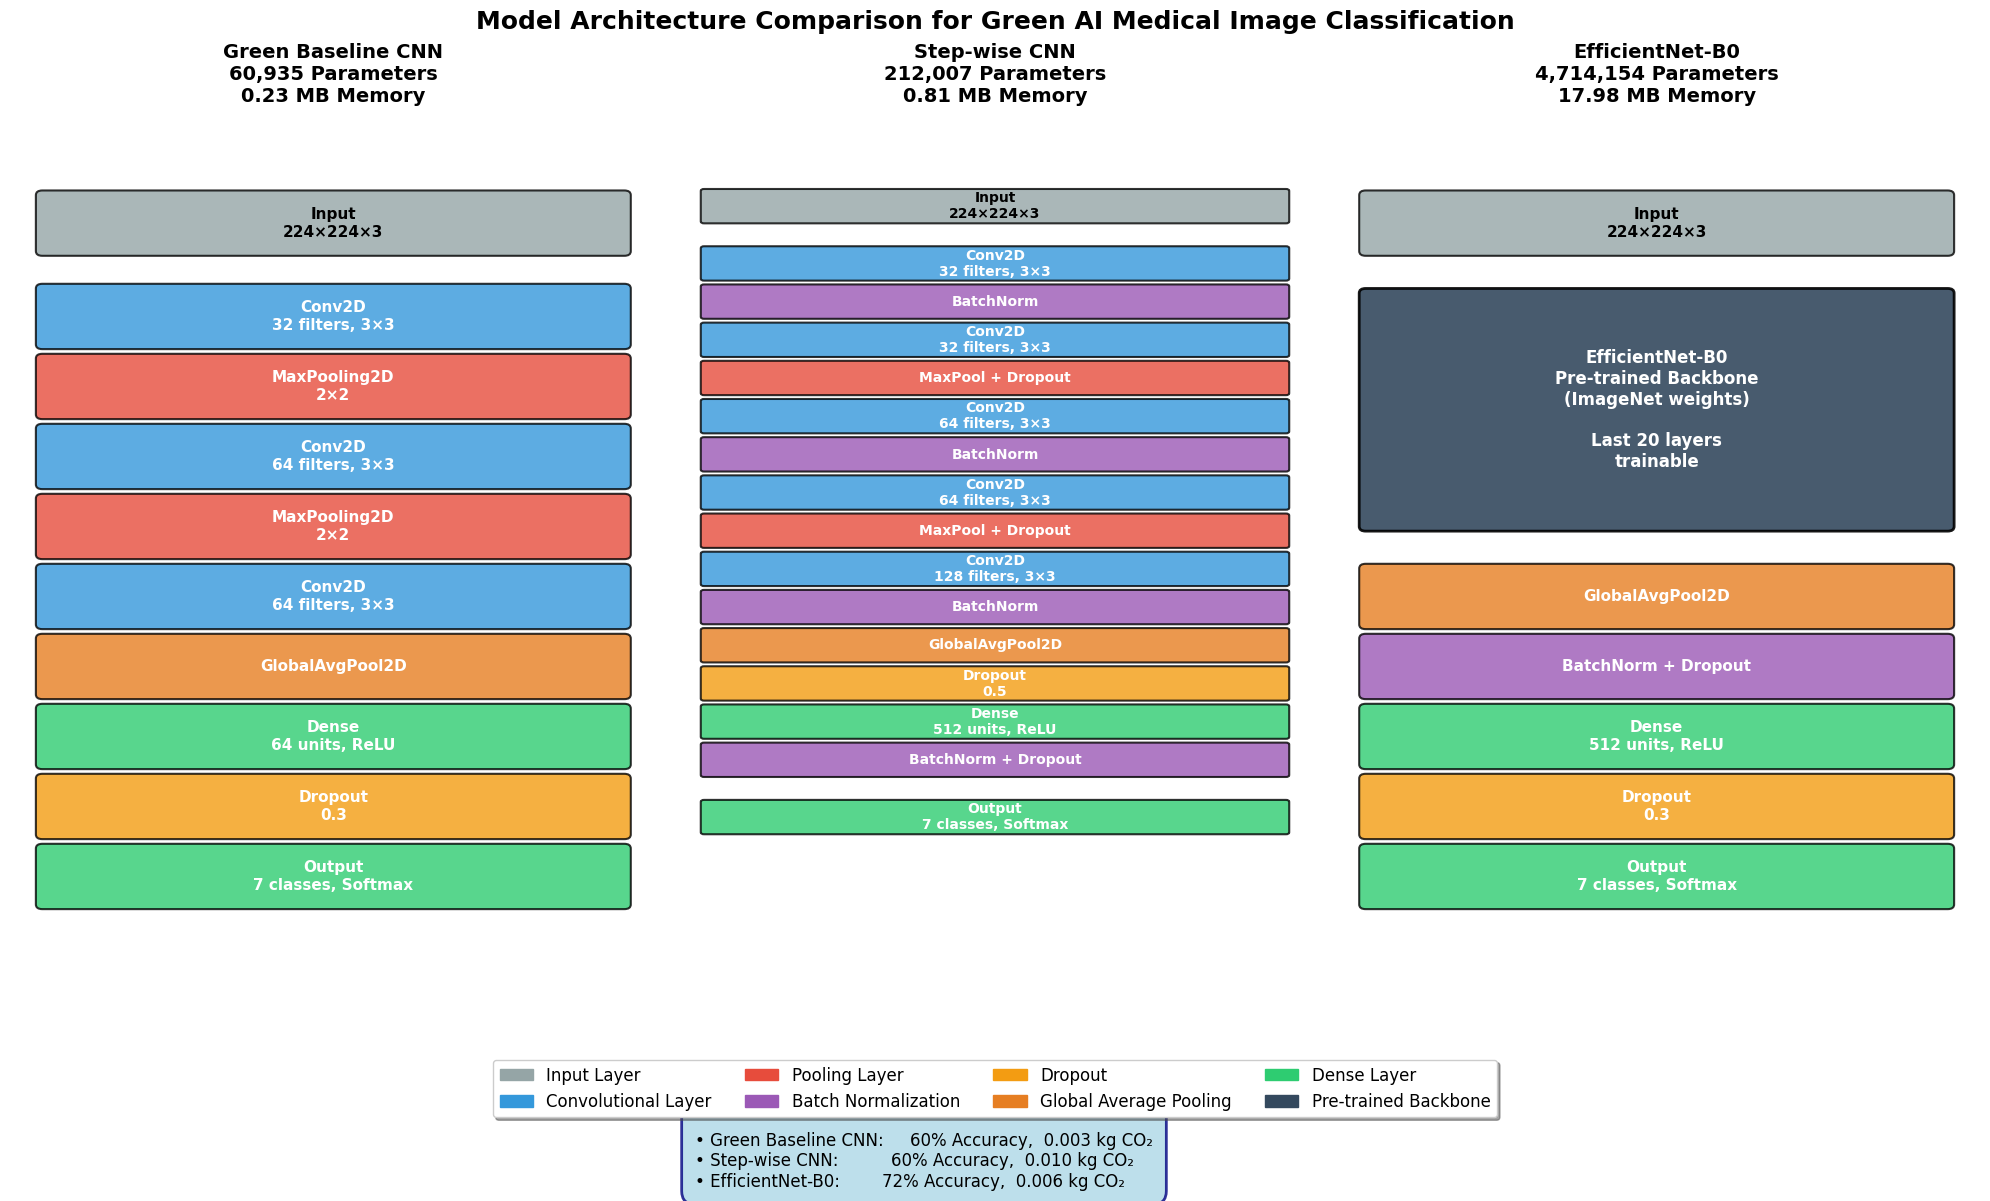

✅ Clean model architecture diagram generated!

Improvements made:
• Larger figure size (20×12)
• Better spacing between layers
• Larger, more readable text
• Clear layer descriptions
• Organized legend with 4 columns
• Performance metrics in separate box
• High contrast colors
• 300 DPI resolution for publication quality


In [15]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import FancyBboxPatch
import numpy as np

def create_model_architecture_diagram():
    """
    Creates a clean and readable model architecture comparison diagram
    """
    fig = plt.figure(figsize=(20, 12))
    
    # Create main title
    fig.suptitle('Model Architecture Comparison for Green AI Medical Image Classification', 
                 fontsize=18, fontweight='bold', y=0.95)
    
    # Colors for different layer types
    colors = {
        'conv': '#3498db',      # Blue
        'pool': '#e74c3c',      # Red
        'dense': '#2ecc71',     # Green
        'dropout': '#f39c12',   # Orange
        'batch_norm': '#9b59b6', # Purple
        'global_pool': '#e67e22', # Dark orange
        'input': '#95a5a6'      # Gray
    }
    
    # Create three subplots with more space
    ax1 = plt.subplot(1, 3, 1)
    ax2 = plt.subplot(1, 3, 2)
    ax3 = plt.subplot(1, 3, 3)
    
    # Model 1: Green Baseline CNN
    ax1.set_title('Green Baseline CNN\n60,935 Parameters\n0.23 MB Memory', 
                  fontweight='bold', fontsize=14, pad=20)
    ax1.set_xlim(0, 10)
    ax1.set_ylim(0, 18)
    ax1.axis('off')
    
    # Define layers with better spacing
    layers_green = [
        ('Input\n224×224×3', 'input', 16),
        ('Conv2D\n32 filters, 3×3', 'conv', 14),
        ('MaxPooling2D\n2×2', 'pool', 12.5),
        ('Conv2D\n64 filters, 3×3', 'conv', 11),
        ('MaxPooling2D\n2×2', 'pool', 9.5),
        ('Conv2D\n64 filters, 3×3', 'conv', 8),
        ('GlobalAvgPool2D', 'global_pool', 6.5),
        ('Dense\n64 units, ReLU', 'dense', 5),
        ('Dropout\n0.3', 'dropout', 3.5),
        ('Output\n7 classes, Softmax', 'dense', 2)
    ]
    
    for layer_name, layer_type, y_pos in layers_green:
        # Create box with better dimensions
        box = FancyBboxPatch((0.5, y_pos-0.6), 9, 1.2, boxstyle="round,pad=0.1",
                            facecolor=colors[layer_type], alpha=0.8, 
                            edgecolor='black', linewidth=1.5)
        ax1.add_patch(box)
        ax1.text(5, y_pos, layer_name, ha='center', va='center', 
                fontsize=11, fontweight='bold', color='white' if layer_type != 'input' else 'black')
    
    # Model 2: Step-wise CNN
    ax2.set_title('Step-wise CNN\n212,007 Parameters\n0.81 MB Memory', 
                  fontweight='bold', fontsize=14, pad=20)
    ax2.set_xlim(0, 10)
    ax2.set_ylim(0, 22)
    ax2.axis('off')
    
    layers_stepwise = [
        ('Input\n224×224×3', 'input', 20),
        ('Conv2D\n32 filters, 3×3', 'conv', 18.5),
        ('BatchNorm', 'batch_norm', 17.5),
        ('Conv2D\n32 filters, 3×3', 'conv', 16.5),
        ('MaxPool + Dropout', 'pool', 15.5),
        ('Conv2D\n64 filters, 3×3', 'conv', 14.5),
        ('BatchNorm', 'batch_norm', 13.5),
        ('Conv2D\n64 filters, 3×3', 'conv', 12.5),
        ('MaxPool + Dropout', 'pool', 11.5),
        ('Conv2D\n128 filters, 3×3', 'conv', 10.5),
        ('BatchNorm', 'batch_norm', 9.5),
        ('GlobalAvgPool2D', 'global_pool', 8.5),
        ('Dropout\n0.5', 'dropout', 7.5),
        ('Dense\n512 units, ReLU', 'dense', 6.5),
        ('BatchNorm + Dropout', 'batch_norm', 5.5),
        ('Output\n7 classes, Softmax', 'dense', 4)
    ]
    
    for layer_name, layer_type, y_pos in layers_stepwise:
        box = FancyBboxPatch((0.5, y_pos-0.4), 9, 0.8, boxstyle="round,pad=0.05",
                            facecolor=colors[layer_type], alpha=0.8, 
                            edgecolor='black', linewidth=1.5)
        ax2.add_patch(box)
        ax2.text(5, y_pos, layer_name, ha='center', va='center', 
                fontsize=10, fontweight='bold', color='white' if layer_type != 'input' else 'black')
    
    # Model 3: EfficientNet-B0
    ax3.set_title('EfficientNet-B0\n4,714,154 Parameters\n17.98 MB Memory', 
                  fontweight='bold', fontsize=14, pad=20)
    ax3.set_xlim(0, 10)
    ax3.set_ylim(0, 18)
    ax3.axis('off')
    
    # Input layer
    input_box = FancyBboxPatch((0.5, 15.4), 9, 1.2, boxstyle="round,pad=0.1",
                              facecolor=colors['input'], alpha=0.8, 
                              edgecolor='black', linewidth=1.5)
    ax3.add_patch(input_box)
    ax3.text(5, 16, 'Input\n224×224×3', ha='center', va='center', 
            fontsize=11, fontweight='bold')
    
    # EfficientNet backbone
    backbone_box = FancyBboxPatch((0.5, 9.5), 9, 5, boxstyle="round,pad=0.1",
                                 facecolor='#34495e', alpha=0.9, 
                                 edgecolor='black', linewidth=2)
    ax3.add_patch(backbone_box)
    ax3.text(5, 12, 'EfficientNet-B0\nPre-trained Backbone\n(ImageNet weights)\n\nLast 20 layers\ntrainable', 
            ha='center', va='center', fontsize=12, fontweight='bold', color='white')
    
    # Custom layers
    custom_layers = [
        ('GlobalAvgPool2D', 'global_pool', 8),
        ('BatchNorm + Dropout', 'batch_norm', 6.5),
        ('Dense\n512 units, ReLU', 'dense', 5),
        ('Dropout\n0.3', 'dropout', 3.5),
        ('Output\n7 classes, Softmax', 'dense', 2)
    ]
    
    for layer_name, layer_type, y_pos in custom_layers:
        box = FancyBboxPatch((0.5, y_pos-0.6), 9, 1.2, boxstyle="round,pad=0.1",
                            facecolor=colors[layer_type], alpha=0.8, 
                            edgecolor='black', linewidth=1.5)
        ax3.add_patch(box)
        ax3.text(5, y_pos, layer_name, ha='center', va='center', 
                fontsize=11, fontweight='bold', color='white')
    
    # Create a cleaner legend
    legend_elements = [
        patches.Patch(color=colors['input'], label='Input Layer'),
        patches.Patch(color=colors['conv'], label='Convolutional Layer'),
        patches.Patch(color=colors['pool'], label='Pooling Layer'),
        patches.Patch(color=colors['batch_norm'], label='Batch Normalization'),
        patches.Patch(color=colors['dropout'], label='Dropout'),
        patches.Patch(color=colors['global_pool'], label='Global Average Pooling'),
        patches.Patch(color=colors['dense'], label='Dense Layer'),
        patches.Patch(color='#34495e', label='Pre-trained Backbone')
    ]
    
    # Position legend at the bottom
    fig.legend(handles=legend_elements, loc='lower center', ncol=4, 
               bbox_to_anchor=(0.5, 0.02), fontsize=12, frameon=True, 
               fancybox=True, shadow=True)
    
    # Add performance comparison box - positioned at bottom right
    performance_text = """Performance & Environmental Impact:
    
• Green Baseline CNN:     60% Accuracy,  0.003 kg CO₂
• Step-wise CNN:          60% Accuracy,  0.010 kg CO₂  
• EfficientNet-B0:        72% Accuracy,  0.006 kg CO₂"""
    
    fig.text(0.35, 0.05, performance_text, fontsize=12, 
             bbox=dict(boxstyle="round,pad=0.8", facecolor='lightblue', 
                      alpha=0.8, edgecolor='navy', linewidth=2),
             verticalalignment='top')
    
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.15, top=0.85)
    
    # Save with high resolution
    plt.savefig('model_architecture_comparison_clean.png', dpi=300, 
                bbox_inches='tight', facecolor='white')
    plt.show()
    
    return fig

# Generate the improved diagram
if __name__ == "__main__":
    create_model_architecture_diagram()
    print("✅ Clean model architecture diagram generated!")
    print("\nImprovements made:")
    print("• Larger figure size (20×12)")
    print("• Better spacing between layers")
    print("• Larger, more readable text")
    print("• Clear layer descriptions")
    print("• Organized legend with 4 columns")
    print("• Performance metrics in separate box")
    print("• High contrast colors")
    print("• 300 DPI resolution for publication quality")